<a href="https://colab.research.google.com/github/Baasty-OCh/Miner-a-curso-/blob/test_colab/P2_T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# No debería ser necesario en Colab para estos paquetes, pero por si acaso:
!pip install pandas openpyxl scikit-learn matplotlib


In [27]:
import numpy as np
import pandas as pd

# Crear los datos
ventas = [
    96, 87, 91, 94, 96, 83, 100, 105, 106, 91,
    106, 95, 101, 72, 86, 85, 99, 104, 94, 116,
    90, 109, 87, 93, 98, 94, 66, 81, 67, 73,
    92, 52, 106, 46, 96, 62, 116, 53, 118, 51,
    64, 81, 69, 87, 63, 86, 88, 99, 105, 130,
    130, 133
]

# Crear las etiquetas de semanas
semanas = [f'W{i}' for i in range(len(ventas))]

# Crear el DataFrame
matriz_ventas = pd.DataFrame([ventas], columns=semanas, index=['Total/semana'])




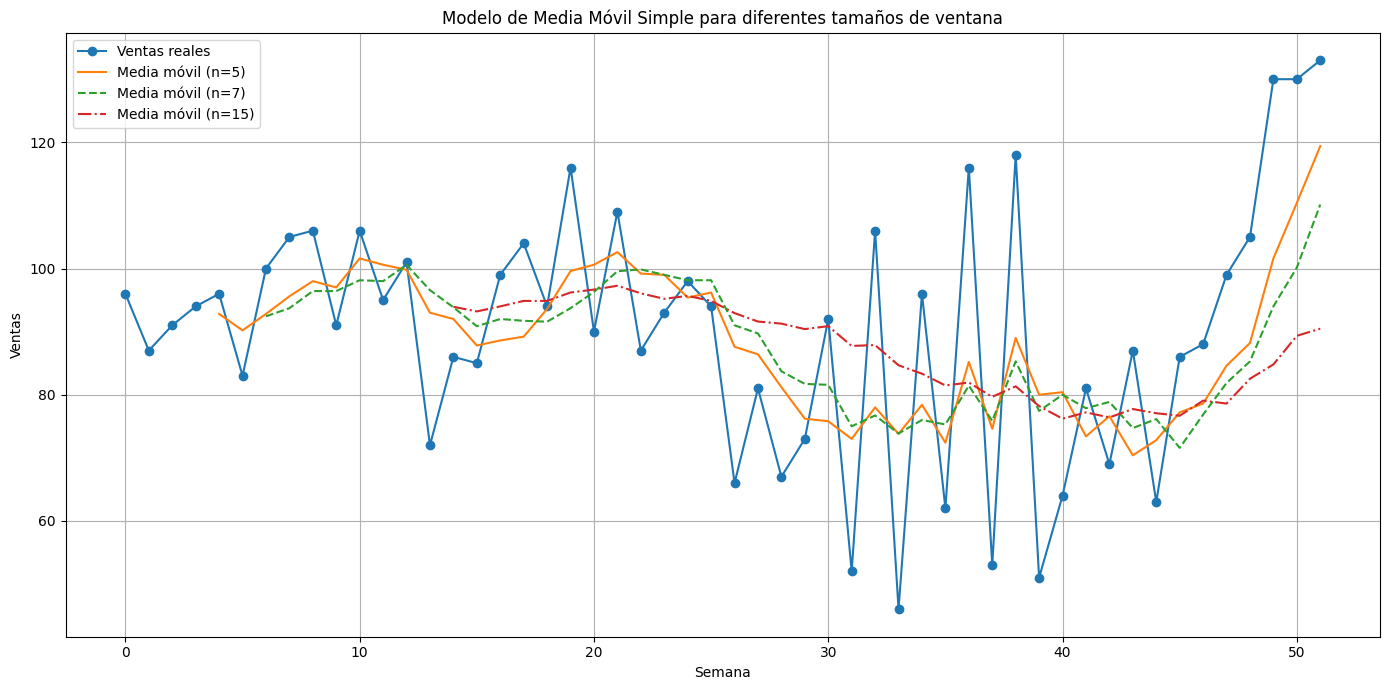

,Tamaño de ventana,MSE
0,5,230.323333
1,7,302.779947
2,15,456.027953


In [29]:
# Primero, convertir los datos a una serie temporal adecuada
ventas_series = matriz_ventas.loc['Total/semana'].astype(float)

# Aplicar medias móviles simples
rolling_5 = ventas_series.rolling(window=5).mean()
rolling_7 = ventas_series.rolling(window=7).mean()
rolling_15 = ventas_series.rolling(window=15).mean()

# Graficar los resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(ventas_series.values, label='Ventas reales', marker='o')
plt.plot(rolling_5.values, label='Media móvil (n=5)', linestyle='-')
plt.plot(rolling_7.values, label='Media móvil (n=7)', linestyle='--')
plt.plot(rolling_15.values, label='Media móvil (n=15)', linestyle='-.')
plt.title('Modelo de Media Móvil Simple para diferentes tamaños de ventana')
plt.xlabel('Semana')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()






In [30]:

# Calcular errores MSE para cada modelo
from sklearn.metrics import mean_squared_error
import numpy as np

def mse_with_nan(real, pred):
    mask = ~np.isnan(pred)
    return mean_squared_error(real[mask], pred[mask])

mse_5 = mse_with_nan(ventas_series.values, rolling_5.values)
mse_7 = mse_with_nan(ventas_series.values, rolling_7.values)
mse_15 = mse_with_nan(ventas_series.values, rolling_15.values)

# Crear un resumen
mse_summary = pd.DataFrame({
    'Tamaño de ventana': [5, 7, 15],
    'MSE': [mse_5, mse_7, mse_15]
})
mse_summary

,Tamaño de ventana,MSE
0,5,230.323333
1,7,302.779947
2,15,456.027953


In [32]:
#El mejor 𝑛 es 5, ya que en primer lugar tiene el menor error según la métrica MSE.
#Esto quiere decir que captura mejor las variaciones semanales, ya que generaliza lo suficiente para evitar el ruido y aun así seguir la tendencia.
#Esto le da mayor sensibilidad a cambios por eventos específicos, es compatible con este ciclo de serie de tiempo,
#y podemos notarlo al ver cómo guarda similitud con la curva que grafica el comportamiento real.

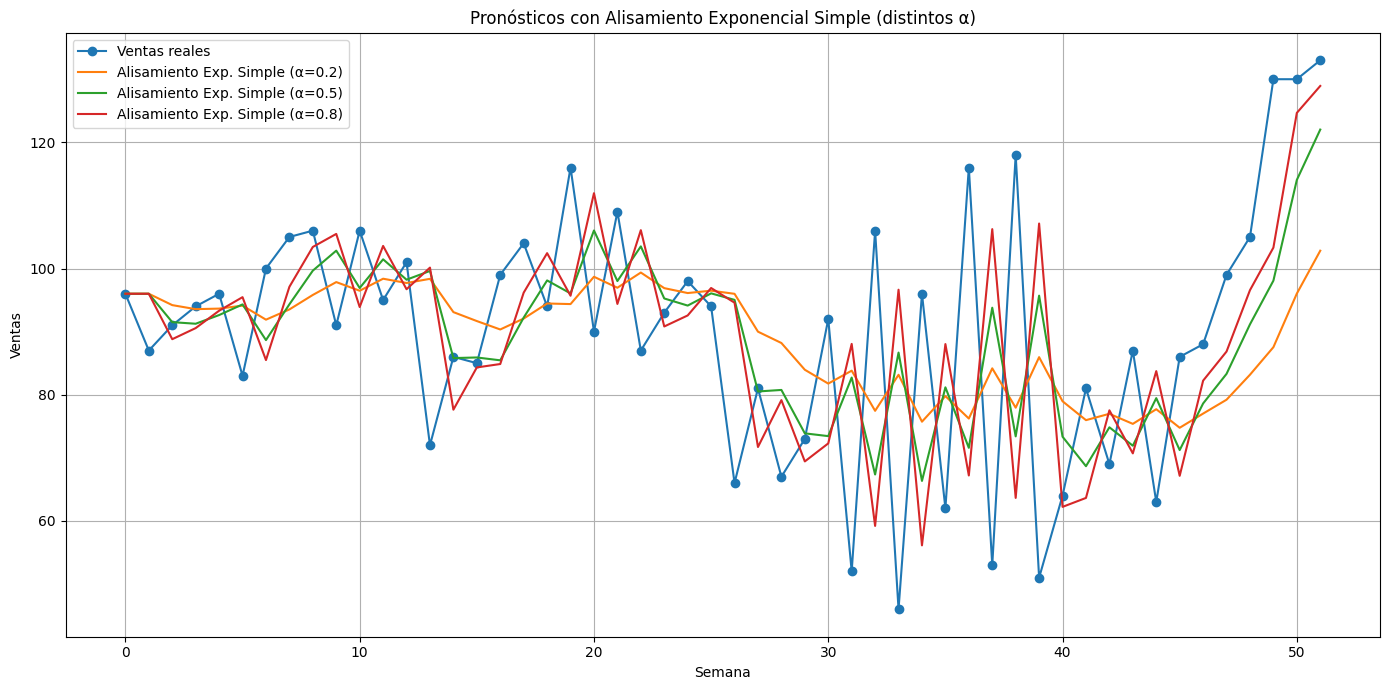

In [34]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Definimos valores de alpha a utilizar
alphas = [0.2, 0.5, 0.8]

# Diccionario para guardar los modelos
ses_models = {}
predictions = {}
mse_values = {}

# Entrenar y predecir usando alisamiento exponencial simple para cada alpha
for alpha in alphas:
    model = SimpleExpSmoothing(ventas_series.values).fit(smoothing_level=alpha, optimized=False)
    pred = model.fittedvalues
    mse = mean_squared_error(ventas_series.values, pred)

    ses_models[alpha] = model
    predictions[alpha] = pred
    mse_values[alpha] = mse

# Graficar los resultados
plt.figure(figsize=(14, 7))
plt.plot(ventas_series.values, label='Ventas reales', marker='o')
for alpha in alphas:
    plt.plot(predictions[alpha], label=f'Alisamiento Exp. Simple (α={alpha})')

plt.title('Pronósticos con Alisamiento Exponencial Simple (distintos α)')
plt.xlabel('Semana')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()






In [36]:
# Crear un resumen de los MSE
mse_summary_alpha = pd.DataFrame({
    'Alpha': list(mse_values.keys()),
    'MSE': list(mse_values.values())
}).sort_values(by='MSE')
mse_summary_alpha

,Alpha,MSE
0,0.2,368.722163
1,0.5,388.624131
2,0.8,523.607615


In [ ]:
#El parametro alfa define cuanto peso se le da a la observación reciente, entre más grande mas importancia se le da a los datos recientes
#Al variarlo cambiamos con cuanta rapidez el modelo se adapata a los cambios reales en la demanda, lo cual se me reflejada en la 'suavidad' de los pronosticos
#Así el alfa = 0.2 crea una curva muy suave en comparación a la de 0.8 (más similar a la original)
#El mejor alfa en todo caso, es el 0.2, ya que tiene menor MSE, esto queire decir que logra filtrar las variaciones aletaorias y se enfoca en la tendencia prinicpal de los datos
# Este alfa pequeño nos permite mantenernos constantes y no inducir a la sobre reaccion ante cambios insignificantes(ej: no pedir100 lapices mas por que la semana pasada se vendieron mucho)
